Using device: mps
Epoch 0 Iter 100: VAE 0.0240 | UNet 0.2835
Epoch 0 Iter 200: VAE 0.0189 | UNet 0.2541
Epoch 0 Iter 300: VAE 0.0131 | UNet 0.3046
Epoch 0 Iter 400: VAE 0.0094 | UNet 0.1848
Epoch 0 Iter 500: VAE 0.0121 | UNet 0.1582
Epoch 0 Iter 600: VAE 0.0091 | UNet 0.1990
Epoch 0 Iter 700: VAE 0.0072 | UNet 0.1446
Epoch 0 Iter 800: VAE 0.0062 | UNet 0.2645
Epoch 0 Iter 900: VAE 0.0065 | UNet 0.1750
Epoch 0 Iter 1000: VAE 0.0057 | UNet 0.2488
Epoch 0 Iter 1100: VAE 0.0054 | UNet 0.0930
Epoch 0 Iter 1200: VAE 0.0058 | UNet 0.1262
Epoch 0 Iter 1300: VAE 0.0059 | UNet 0.2587
Epoch 0 Iter 1400: VAE 0.0064 | UNet 0.0784
Epoch 0 Iter 1500: VAE 0.0059 | UNet 0.2180
Epoch 0 Iter 1600: VAE 0.0068 | UNet 0.1741
Epoch 0 Iter 1700: VAE 0.0062 | UNet 0.2196
Epoch 0 Iter 1800: VAE 0.0050 | UNet 0.1398
Epoch 0 Iter 1900: VAE 0.0051 | UNet 0.2245
Epoch 0 Iter 2000: VAE 0.0063 | UNet 0.3046
Epoch 0 Iter 2100: VAE 0.0070 | UNet 0.3419
Epoch 0 Iter 2200: VAE 0.0049 | UNet 0.2157
Epoch 0 Iter 2300: VAE 

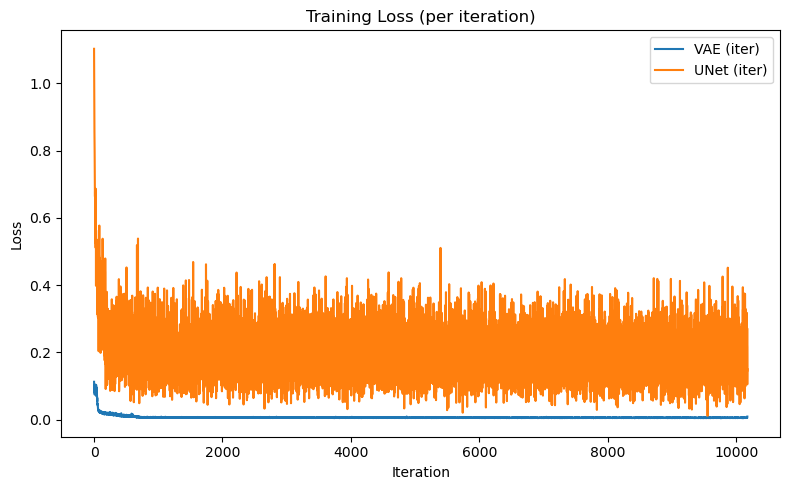

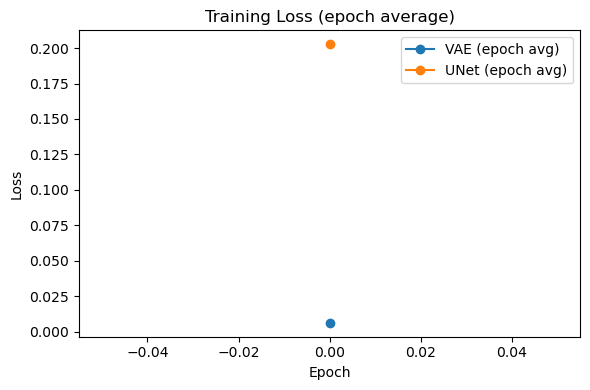

In [2]:
# Consolidated LDM (VAE + UNet + Diffusion) for CelebA 256x256

import math
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt

# -------------------------
# Device
# -------------------------
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print("Using device:", device)

# -------------------------
# Helpers
# -------------------------
def GN(c: int) -> nn.GroupNorm:
    return nn.GroupNorm(num_groups=min(32, c), num_channels=c)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, timesteps: torch.Tensor):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb

# -------------------------
# VAE (conv)
# -------------------------
class VAE(nn.Module):
    def __init__(self, z_dim=4, in_ch=3, base=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, base, 3, stride=2, padding=1), nn.SiLU(),
            nn.Conv2d(base, base*2, 3, stride=2, padding=1), nn.SiLU(),
            nn.Conv2d(base*2, base*4, 3, stride=2, padding=1), nn.SiLU(),
            nn.Conv2d(base*4, base*8, 3, stride=2, padding=1), nn.SiLU()
        )
        self.mu     = nn.Conv2d(base*8, z_dim, 1)
        self.logvar = nn.Conv2d(base*8, z_dim, 1)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(z_dim, base*8, 4, stride=2, padding=1), nn.SiLU(),
            nn.ConvTranspose2d(base*8, base*4, 4, stride=2, padding=1), nn.SiLU(),
            nn.ConvTranspose2d(base*4, base*2, 4, stride=2, padding=1), nn.SiLU(),
            nn.ConvTranspose2d(base*2, base,   4, stride=2, padding=1), nn.SiLU(),
            nn.Conv2d(base, in_ch, 3, padding=1),
            nn.Sigmoid()
        )

    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparam(mu, logvar)
        x_hat = self.dec(z)
        return x_hat, mu, logvar

# -------------------------
# UNet building blocks
# -------------------------
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim: Optional[int] = None):
        super().__init__()
        self.norm1 = GN(in_ch)
        self.act   = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.norm2 = GN(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.time_mlp = None
        if time_emb_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_emb_dim, out_ch)
            )

        self.skip = (in_ch != out_ch)
        if self.skip:
            self.proj = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x, t_emb=None):
        h = self.conv1(self.act(self.norm1(x)))
        if self.time_mlp is not None and t_emb is not None:
            h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = self.conv2(self.act(self.norm2(h)))
        if self.skip:
            x = self.proj(x)
        return x + h

class SelfAttention2d(nn.Module):
    def __init__(self, ch, num_heads=4):
        super().__init__()
        assert ch % num_heads == 0
        self.norm = GN(ch)
        self.q = nn.Conv2d(ch, ch, 1)
        self.k = nn.Conv2d(ch, ch, 1)
        self.v = nn.Conv2d(ch, ch, 1)
        self.proj = nn.Conv2d(ch, ch, 1)
        self.num_heads = num_heads
        self.head_dim = ch // num_heads
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        b, c, h, w = x.shape
        x_n = self.norm(x)
        q = self.q(x_n)
        k = self.k(x_n)
        v = self.v(x_n)
        q = q.view(b, self.num_heads, self.head_dim, h*w)
        k = k.view(b, self.num_heads, self.head_dim, h*w)
        v = v.view(b, self.num_heads, self.head_dim, h*w)
        attn = torch.einsum('bhdn,bhdm->bhnm', q, k) * self.scale
        attn = attn.softmax(dim=-1)
        out = torch.einsum('bhnm,bhdm->bhdn', attn, v)
        out = out.reshape(b, c, h, w)
        out = self.proj(out)
        return x + out

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, with_attn=False):
        super().__init__()
        self.block1 = ResBlock(in_ch,  out_ch, time_dim)
        self.block2 = ResBlock(out_ch, out_ch, time_dim)
        self.attn   = SelfAttention2d(out_ch) if with_attn else nn.Identity()
        self.down   = nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)

    def forward(self, x, t):
        x = self.block1(x, t)
        x = self.block2(x, t)
        x = self.attn(x)
        skip = x
        x = self.down(x)
        return x, skip

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, time_dim, with_attn=False):
        super().__init__()
        self.up    = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.block1 = ResBlock(out_ch + skip_ch, out_ch, time_dim)
        self.block2 = ResBlock(out_ch,           out_ch, time_dim)
        self.attn   = SelfAttention2d(out_ch) if with_attn else nn.Identity()

    def forward(self, x, skip, t):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="nearest")
        x = torch.cat([x, skip], dim=1)
        x = self.block1(x, t)
        x = self.block2(x, t)
        x = self.attn(x)
        return x

class UNet(nn.Module):
    def __init__(self, z_dim=4, base=64, time_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(base),
            nn.Linear(base, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )
        self.in_conv = nn.Conv2d(z_dim, base, 3, padding=1)
        self.d1 = Down(base,       base,       time_dim, with_attn=False)
        self.d2 = Down(base,       base*2,     time_dim, with_attn=True)
        self.d3 = Down(base*2,     base*4,     time_dim, with_attn=True)
        self.d4 = Down(base*4,     base*8,     time_dim, with_attn=True)
        self.mid1 = ResBlock(base*8, base*8, time_dim)
        self.mid_attn = SelfAttention2d(base*8)
        self.mid2 = ResBlock(base*8, base*8, time_dim)
        self.u1 = Up(in_ch=base*8,  skip_ch=base*8,  out_ch=base*4,  time_dim=time_dim, with_attn=True)
        self.u2 = Up(in_ch=base*4,  skip_ch=base*4,  out_ch=base*2,  time_dim=time_dim, with_attn=True)
        self.u3 = Up(in_ch=base*2,  skip_ch=base*2,  out_ch=base,    time_dim=time_dim, with_attn=True)
        self.u4 = Up(in_ch=base,    skip_ch=base,    out_ch=base,    time_dim=time_dim, with_attn=False)
        self.out_norm = GN(base)
        self.out_act  = nn.SiLU()
        self.out_conv = nn.Conv2d(base, z_dim, 1)

    def forward(self, x, t: torch.Tensor):
        t_emb = self.time_mlp(t)
        x = self.in_conv(x)
        x, s1 = self.d1(x, t_emb)
        x, s2 = self.d2(x, t_emb)
        x, s3 = self.d3(x, t_emb)
        x, s4 = self.d4(x, t_emb)
        x = self.mid1(x, t_emb)
        x = self.mid_attn(x)
        x = self.mid2(x, t_emb)
        x = self.u1(x, s4, t_emb)
        x = self.u2(x, s3, t_emb)
        x = self.u3(x, s2, t_emb)
        x = self.u4(x, s1, t_emb)
        x = self.out_conv(self.out_act(self.out_norm(x)))
        return x

# -------------------------
# Diffusion utils (DDPM)
# -------------------------
class Diffusion(nn.Module):
    def __init__(self, timesteps=1000, device="cpu", schedule="linear"):
        super().__init__()
        self.timesteps = timesteps
        self.device = device
        if schedule == "linear":
            beta = torch.linspace(1e-4, 0.02, timesteps)
        else:
            steps = torch.arange(timesteps + 1, dtype=torch.float64)
            s = 0.008
            alphas_cumprod = torch.cos(((steps / timesteps) + s) / (1 + s) * math.pi / 2) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            beta = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            beta = beta.clamp(1e-8, 0.999)
        alphas = 1.0 - beta
        alphas_cum = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", beta.float())
        self.register_buffer("alphas", alphas.float())
        self.register_buffer("alphas_cum", alphas_cum.float())
        self.register_buffer("sqrt_alphas_cum", torch.sqrt(alphas_cum).float())
        self.register_buffer("sqrt_one_minus_alphas_cum", torch.sqrt(1 - alphas_cum).float())

    def sample_timesteps(self, b: int) -> torch.Tensor:
        return torch.randint(low=1, high=self.timesteps, size=(b,), device=self.device)

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, noise: Optional[torch.Tensor] = None) -> torch.Tensor:
        if noise is None:
            noise = torch.randn_like(x0)
        # ensure t is on same device as buffers
        t = t.long().to(self.sqrt_alphas_cum.device)
        sqrt_ac  = self.sqrt_alphas_cum[t].view(-1, 1, 1, 1)
        sqrt_oma = self.sqrt_one_minus_alphas_cum[t].view(-1, 1, 1, 1)
        return sqrt_ac * x0 + sqrt_oma * noise

# -------------------------
# Data
# -------------------------
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])
dataset = datasets.CelebA(root="./data", split="train", download=False, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)

# -------------------------
# Instantiate models
# -------------------------
z_dim = 4
vae  = VAE(z_dim=z_dim).to(device)
unet = UNet(z_dim=z_dim).to(device)
diff = Diffusion(device=device).to(device)

opt_vae  = torch.optim.Adam(vae.parameters(),  1e-4)
opt_unet = torch.optim.Adam(unet.parameters(), 1e-4)

# -------------------------
# Training + loss tracking
# -------------------------
epochs = 1  # increase later
vae.train(); unet.train()

vae_losses_iter  = []  # per-iteration
unet_losses_iter = []
vae_losses_epoch = []  # per-epoch averages
unet_losses_epoch = []

for epoch in range(epochs):
    vae_running, unet_running = 0.0, 0.0
    num_batches = 0

    for i, (imgs, _) in enumerate(dataloader):
        num_batches += 1
        imgs = imgs.to(device)

        # ---- VAE step ----
        recons, mu, logvar = vae(imgs)
        recon_loss = F.mse_loss(recons, imgs)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        vae_loss = recon_loss + 1e-3 * kl
        opt_vae.zero_grad()
        vae_loss.backward()
        opt_vae.step()

        # ---- Diffusion step ----
        with torch.no_grad():
            h = vae.enc(imgs)
            mu = vae.mu(h)
            logvar = vae.logvar(h)
            z = vae.reparam(mu, logvar)

        t = diff.sample_timesteps(z.size(0)).to(device)
        noise = torch.randn_like(z)
        x_t = diff.q_sample(z, t, noise)
        noise_pred = unet(x_t, t.float())
        d_loss = F.mse_loss(noise_pred, noise)

        opt_unet.zero_grad()
        d_loss.backward()
        opt_unet.step()

        # ---- track losses
        vae_losses_iter.append(vae_loss.item())
        unet_losses_iter.append(d_loss.item())
        vae_running += vae_loss.item()
        unet_running += d_loss.item()

        if (i + 1) % 100 == 0:
            print(f"Epoch {epoch} Iter {i+1}: VAE {vae_loss.item():.4f} | UNet {d_loss.item():.4f}")

    # epoch averages
    vae_epoch_avg = vae_running / max(1, num_batches)
    unet_epoch_avg = unet_running / max(1, num_batches)
    vae_losses_epoch.append(vae_epoch_avg)
    unet_losses_epoch.append(unet_epoch_avg)
    print(f"[Epoch {epoch}] VAE {vae_epoch_avg:.4f} | UNet {unet_epoch_avg:.4f}")

# -------------------------
# Sampler (DDPM; stochastic)
# -------------------------
@torch.no_grad()
def sample_unet(num=4, steps: Optional[int] = None):
    vae.eval(); unet.eval()
    z = torch.randn(num, z_dim, 16, 16, device=device)
    T = diff.timesteps
    if steps is None or steps >= T:
        ts = list(reversed(range(1, T)))
    else:
        idxs = torch.linspace(1, T-1, steps, dtype=torch.long).tolist()
        ts = list(reversed([int(i) for i in idxs]))

    for t in ts:
        t_batch = torch.full((num,), t, device=device).float()
        eps = unet(z, t_batch)
        alpha_t = diff.alphas[t]
        alpha_cum_t = diff.alphas_cum[t]
        beta_t = diff.betas[t]
        z = (z - (1 - alpha_t) / (1 - alpha_cum_t).sqrt() * eps) / alpha_t.sqrt()
        if t > 1:
            z = z + beta_t.sqrt() * torch.randn_like(z)

    x = vae.dec(z).clamp(0, 1)
    return x

# -------------------------
# Demo sampling
# -------------------------
samples = sample_unet(num=8, steps=50)
grid = make_grid(samples, nrow=4)
save_image(grid, "ldm_celeb_samples.png")
print("Saved samples -> ldm_celeb_samples.png")

# -------------------------
# Plot and save losses
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(vae_losses_iter, label="VAE (iter)")
plt.plot(unet_losses_iter, label="UNet (iter)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss (per iteration)")
plt.legend()
plt.tight_layout()
plt.savefig("training_losses_iter.png", dpi=150)
print("Saved loss plot -> training_losses_iter.png")

plt.figure(figsize=(6, 4))
plt.plot(vae_losses_epoch, marker="o", label="VAE (epoch avg)")
plt.plot(unet_losses_epoch, marker="o", label="UNet (epoch avg)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (epoch average)")
plt.legend()
plt.tight_layout()
plt.savefig("training_losses.png", dpi=150)
print("Saved loss plot -> training_losses.png")


In [3]:
len(dataset)

162770